# PyCPT Seasonal

#### Authors: 
Nachiketa Acharya (nachiketa@iri.columbia.edu), Kyle Hall (kjh2171@columbia.edu)

#### Original Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Simon J. Mason (simon@iri.columbia.edu)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).


#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.


### Namelist section

In [1]:
########Work name (name of the work folder; e.g., one word followed by "_seasonal":)
work = 'Test_oy4'

########Some folder and file options:
# Where do you want to make the work folder-- this should already exist!!!
workdir = "C:/Users/sysadmin/Projects/PyCPT-Dev/"
# PATH to CPT directory (folder containing CPT.x)
cptdir='C:/CPT/'
shp_file = 'None' #path from pycpt_functions_seasonal.py to your shape file
use_default = 'True' #Make False to turn off default country boundaries

########Model (choose one, a subset or all models: 
#CMC1-CanCM3, CMC2-CanCM4,  COLA-RSMAS-CCSM4*, GFDL-CM2p5-FLOR-A06*, GFDL-CM2p5-FLOR-B01*,GFDL-CM2p1-aer04*, NASA-GEOSS2S*, NCEP-CFSv2*)
#The ones with "*" are producing operational forecasts, the others are frozen. 
models=['CanSIPSv2','COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','NASA-GEOSS2S','NCEP-CFSv2']


#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow', 'RMSE'):
met=['Pearson']#,'Spearman']#,'2AFC','RocAbove','RocBelow', 'RMSE']

########Obs (choose between CPC-CMAP-URD, CHIRPS, TRMM, CPC, Chilestations,GPCC)
obs='ENACTS-BD'
station=False

########MOS method (choose between None, PCR, CCA) #Esto es calibracion
MOS='PCR' 


#only used if MOS == 'CCA' or MOS == 'PCR'
xmodes_min = 1
xmodes_max = 8
ymodes_min = 2
ymodes_max = 10
ccamodes_min = 1
ccamodes_max = 5
eofmodes = 3 #number of EOF modes to compute

########Predictand (choose between PRCP, RFREQ)
PREDICTAND='PRCP'

########Predictor (choose between GCM's PRCP, VQ, UQ)
#VQ and UQ only works with models=['NCEP-CFSv2']
PREDICTOR='PRCP'

########Target seasons and related parameters
##If more targets, increase the arrays accordingly
#mons=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mons=[ 'May', 'Sep']
tgti=['1.5', '1.5']  #S: start for the DL
tgtf=['4.5', '3.5']   #S: end for the DL
#for now, just write the target period (for DL)
#tgts=['Feb-Apr','Mar-May','Apr-Jun','May-Jul','Jun-Aug','Jul-Sep','Aug-Oct','Sep-Nov','Oct-Dec','Nov-Jan','Dec-Feb','Jan-Mar'] 
tgts=['Jun-Sep', 'Oct-Dec']

tini = 1982
tend = 2009

########Forecast date  
monf=['May', 'Sep'] 	# Initialization month 
fyr=2020 	# Forecast year

########Switches: 
force_download = False   #force download of data files, even if they already exist locally --- IF YOU ALREADY HAVE OBS FILES, DOUBLE CHECK WHICH ONES THEY ARE --- True to be safe

# ########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=15 	# Southernmost latitude
wlo1=80 	# Westernmost longitude
elo1=100 	# Easternmost longitude
# Spatial domain for predictand
nla2=28 	# Northernmost latitude
sla2=20 	# Southernmost latitude
wlo2=87 	# Westernmost longitude
elo2=94 	# Easternmost longitude



### End of namelist section 

#### Load Libraries

In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from scipy.stats import t
if MOS=='ELR':
    from sklearn.linear_model import LogisticRegression
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
import platform


pycpt = PyCPT_Args(cptdir, models, met, obs, station, MOS, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, eofmodes, PREDICTAND, PREDICTOR, mons, tgti, tgtf, tgts, tini, tend, monf, fyr, force_download, nla1, sla1, wlo1, elo1, nla2, sla2, wlo2, elo2, shp_file, use_default)
setup_directories(work, workdir, force_download, cptdir)
pycpt.setupParams(0)


Predictand is Rainfall Total (mm)


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

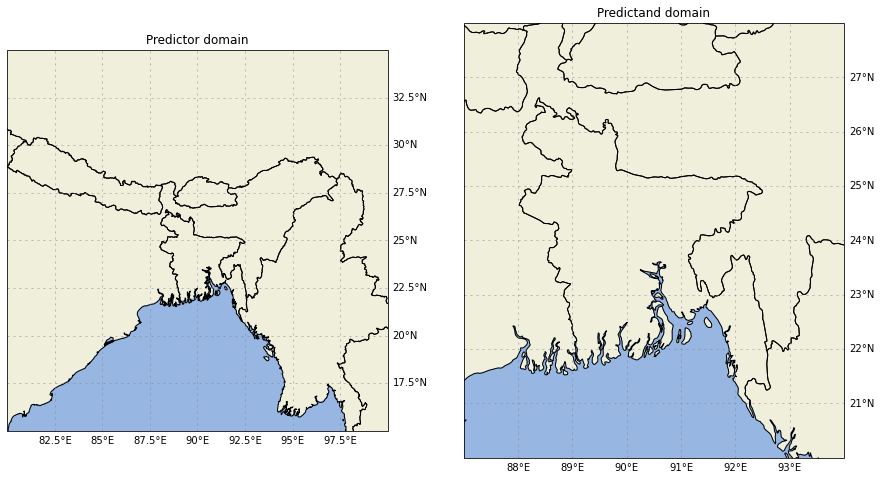

In [3]:
#Plot domains
pycpt.pltdomain()

# Download data if necessary, and run CPT

In [4]:

#If downloadling data from several models, this section might take a while to be done
for model in range(len(models)):
    print('\n\n\n--------Starting process for '+models[model]+'--------')
    for tgt in range(len(mons)):
    
        ########Set Up Useful Variables Automatically - tini & tend may change based on tgt
        pycpt.setupParams(tgt)
            
        #download input files for CPT
        pycpt.prepFiles(tgt, model)
        
        #write CPT input script automatically
        pycpt.CPTscript(tgt, model)
        
        #run CPT
        pycpt.run(tgt, model)
        




--------Starting process for CanSIPSv2--------
Predictand is Rainfall Total (mm)
Preparing CPT files for CanSIPSv2 and initialization May...
Hindcasts file ready to go
----------------------------------------------
Obs file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
        1 file(s) copied.
Executing CPT for CanSIPSv2 and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_CanSIPSv2_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for CanSIPS

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   666k      0 --:--:-- --:--:-- --:--:--  668k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-A06/.MONTHLY/.prec/S/%280000%201%20Sep%202020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 49152    0     0  21942      0  0:04:30  0:00:02  0:04:28 21942
  3 5791k    3  184k    0     0  55942      0  0:01:46  0:00:03  0:01:43 55942
  4 5791k    4  280k    0     0  67558      0  0:01:27  0:00:04  0:01:23 67542
  8 5791k    8  480k    0     0  89091      0  0:01:06  0:00:05  0:01:01 95906
 11 5791k   11  640k    0     0    99k      0  0:00:58  0:00:06  0:00:52  124k
 14 5791k   14  824k    0     0   111k      0  0:00:51  0:00:07  0:00:44  151k
 18 5791k   18 1100k    0     0   130k      0  0:00:44  0:00:08  0:00:36  181k
 24 5791k   24 1424k    0     0   154k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  19266      0 --:--:-- --:--:-- --:--:-- 19266


        1 file(s) copied.
Executing CPT for GFDL-CM2p5-FLOR-A06 and initialization Sep...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-A06_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------






--------Starting process for GFDL-CM2p5-FLOR-B01--------
Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p5-FLOR-B01 and initialization May...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-B01/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2  180k    2  4096    0     0   7037      0  0:00:26 --:--:--  0:00:26 10138
100  180k  100  180k    0     0   305k      0 --:--:-- --:--:-- --:--:--  439k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-B01/.MONTHLY/.prec/S/%280000%201%20May%202020%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 57344    0     0  23637      0  0:04:10  0:00:02  0:04:08 23637
  1 5791k    1  104k    0     0  31837      0  0:03:06  0:00:03  0:03:03 31837
  2 5791k    2  168k    0     0  40316      0  0:02:27  0:00:04  0:02:23 40316
  5 5791k    5  304k    0     0  56640      0  0:01:44  0:00:05  0:01:39 59035
  8 5791k    8  480k    0     0  76513      0  0:01:17  0:00:06  0:01:11 94396
 10 5791k   10  608k    0     0  84821      0  0:01:09  0:00:07  0:01:02  112k
 13 5791k   13  792k    0     0  98173      0  0:01:00  0:00:08  0:00:52  139k
 16 5791k   16  984k    0     0   107k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  41251      0 --:--:-- --:--:-- --:--:-- 41251


        1 file(s) copied.
Executing CPT for GFDL-CM2p5-FLOR-B01 and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-B01_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p5-FLOR-B01 and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-B01/.MONTHLY/.prec/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   301k      0 --:--:-- --:--:-- --:--:--  301k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p5-FLOR-B01/.MONTHLY/.prec/S/%280000%201%20Sep%202020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0  4096    0     0   3180      0  0:31:04  0:00:01  0:31:03  3180
  1 5791k    1 65536    0     0  26047      0  0:03:47  0:00:02  0:03:45 26037
  2 5791k    2  128k    0     0  38124      0  0:02:35  0:00:03  0:02:32 38113
  3 5791k    3  204k    0     0  47922      0  0:02:03  0:00:04  0:01:59 47911
  5 5791k    5  332k    0     0  64363      0  0:01:32  0:00:05  0:01:27 69155
  9 5791k    9  528k    0     0  83039      0  0:01:11  0:00:06  0:01:05  100k
 12 5791k   12  704k    0     0  96998      0  0:01:01  0:00:07  0:00:54  130k
 15 5791k   15  900k    0     0   107k      0  0:00:53  0:00:08  0:00:45  157k
 19 5791k   19 1120k    0     0   120k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  20437      0 --:--:-- --:--:-- --:--:-- 20437


        1 file(s) copied.
Executing CPT for GFDL-CM2p5-FLOR-B01 and initialization Sep...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p5-FLOR-B01_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------






--------Starting process for GFDL-CM2p1-aer04--------
Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p1-aer04 and initialization May...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p1-aer04/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   376k      0 --:--:-- --:--:-- --:--:--  375k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p1-aer04/.MONTHLY/.prec/S/%280000%201%20May%202020%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 57344    0     0  24033      0  0:04:06  0:00:02  0:04:04 24033
  1 5791k    1  104k    0     0  32193      0  0:03:04  0:00:03  0:03:01 32193
  3 5791k    3  216k    0     0  48761      0  0:02:01  0:00:04  0:01:57 48761
  6 5791k    6  348k    0     0  65301      0  0:01:30  0:00:05  0:01:25 70662
  8 5791k    8  488k    0     0  78312      0  0:01:15  0:00:06  0:01:09   99k
 10 5791k   10  636k    0     0  89214      0  0:01:06  0:00:07  0:00:59  118k
 15 5791k   15  888k    0     0   105k      0  0:00:54  0:00:08  0:00:46  153k
 19 5791k   19 1124k    0     0   120k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  19489      0 --:--:-- --:--:-- --:--:-- 19489


        1 file(s) copied.
Executing CPT for GFDL-CM2p1-aer04 and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p1-aer04_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for GFDL-CM2p1-aer04 and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p1-aer04/.MONTHLY/.prec/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   555k      0 --:--:-- --:--:-- --:--:--  557k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-CM2p1-aer04/.MONTHLY/.prec/S/%280000%201%20Sep%202020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0 28672    0     0  15186      0  0:06:30  0:00:01  0:06:29 15186
  2 5791k    2  124k    0     0  40736      0  0:02:25  0:00:03  0:02:22 40749
  3 5791k    3  228k    0     0  57804      0  0:01:42  0:00:04  0:01:38 57818
  5 5791k    5  336k    0     0  69367      0  0:01:25  0:00:04  0:01:21 69367
  9 5791k    9  548k    0     0  90669      0  0:01:05  0:00:06  0:00:59  105k
 12 5791k   12  732k    0     0   102k      0  0:00:56  0:00:07  0:00:49  134k
 16 5791k   16  944k    0     0   117k      0  0:00:49  0:00:08  0:00:41  166k
 20 5791k   20 1168k    0     0   130k      0  0:00:44  0:00:08  0:00:36  191k
 24 5791k   24 1436k    0     0   145k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  47020      0 --:--:-- --:--:-- --:--:-- 47352


        1 file(s) copied.
Executing CPT for GFDL-CM2p1-aer04 and initialization Sep...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_GFDL-CM2p1-aer04_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------






--------Starting process for NASA-GEOSS2S--------
Predictand is Rainfall Total (mm)
Preparing CPT files for NASA-GEOSS2S and initialization May...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDG

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   313k      0 --:--:-- --:--:-- --:--:--  437k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/S/%280000%201%20May%202020%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0 16384    0     0   9046      0  0:10:55  0:00:01  0:10:54  9046
  1 5791k    1 81920    0     0  26965      0  0:03:39  0:00:03  0:03:36 26973
  2 5791k    2  160k    0     0  41373      0  0:02:23  0:00:03  0:02:20 41373
  4 5791k    4  256k    0     0  54161      0  0:01:49  0:00:04  0:01:45 54161
  7 5791k    7  452k    0     0  75752      0  0:01:18  0:00:06  0:01:12 88651
 10 5791k   10  600k    0     0  87884      0  0:01:07  0:00:06  0:01:01  112k
 13 5791k   13  808k    0     0   101k      0  0:00:57  0:00:07  0:00:50  148k
 17 5791k   17 1020k    0     0   114k      0  0:00:50  0:00:08  0:00:42  174k
 23 5791k   23 1340k    0     0   132k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  33287      0 --:--:-- --:--:-- --:--:-- 33452


        1 file(s) copied.
Executing CPT for NASA-GEOSS2S and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NASA-GEOSS2S_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for NASA-GEOSS2S and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   345k      0 --:--:-- --:--:-- --:--:--  502k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/S/%280000%201%20Sep%202020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0 16384    0     0   9881      0  0:10:00  0:00:01  0:09:59  9875
  1 5791k    1 81920    0     0  31751      0  0:03:06  0:00:02  0:03:04 31751
  2 5791k    2  152k    0     0  44445      0  0:02:13  0:00:03  0:02:10 44445
  4 5791k    4  276k    0     0  60260      0  0:01:38  0:00:04  0:01:34 60260
  7 5791k    7  416k    0     0  75368      0  0:01:18  0:00:05  0:01:13 86652
  9 5791k    9  544k    0     0  84749      0  0:01:09  0:00:06  0:01:03  107k
 12 5791k   12  728k    0     0  99462      0  0:00:59  0:00:07  0:00:52  131k
 16 5791k   16  972k    0     0   111k      0  0:00:51  0:00:08  0:00:43  157k
 20 5791k   20 1208k    0     0   125k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  31867      0 --:--:-- --:--:-- --:--:-- 31867


        1 file(s) copied.
Executing CPT for NASA-GEOSS2S and initialization Sep...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_NASA-GEOSS2S_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------






--------Starting process for NCEP-CFSv2--------
Predictand is Rainfall Total (mm)
Preparing CPT files for NCEP-CFSv2 and initialization May...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.prec/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/appendstream/S/%280000%201%20May%201982-2009%29/VALUES/L/1.5/4.5/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   333k      0 --:--:-- --:--:-- --:--:--  374k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.EARLY_MONTH_SAMPLES/.MONTHLY/.prec/S/%280000%201%20May%202020%29/VALUES/L/1.5/4.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/120/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 5791k    0 28672    0     0  13068      0  0:07:33  0:00:02  0:07:31 13068
  1 5791k    1  100k    0     0  32841      0  0:03:00  0:00:03  0:02:57 32852
  3 5791k    3  176k    0     0  44620      0  0:02:12  0:00:04  0:02:08 44631
  4 5791k    4  256k    0     0  52862      0  0:01:52  0:00:04  0:01:48 52862
  7 5791k    7  436k    0     0  72138      0  0:01:22  0:00:06  0:01:16 89507
 10 5791k   10  588k    0     0  84685      0  0:01:10  0:00:07  0:01:03  113k
 13 5791k   13  764k    0     0  97402      0  0:01:00  0:00:08  0:00:52  135k
 18 5791k   18 1044k    0     0   112k      0  0:00:51  0:00:09  0:00:42  166k
 22 5791k   22 1280k    0     0   125k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  47352      0 --:--:-- --:--:-- --:--:-- 47352


        1 file(s) copied.
Executing CPT for NCEP-CFSv2 and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NCEP-CFSv2_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Predictand is Rainfall Total (mm)
Preparing CPT files for NCEP-CFSv2 and initialization Sep...

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES/.MONTHLY/.prec/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/appendstream/S/%280000%201%20Sep%201982-2009%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/15/35/RANGEEDGE

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  180k  100  180k    0     0   317k      0 --:--:-- --:--:-- --:--:--  317k


Obs file ready to go
----------------------------------------------

 Obs (Freq) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.EARLY_MONTH_SAMPLES/.MONTHLY/.prec/S/%280000%201%20Sep%202020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5D/average/Y/15/35/RANGEEDGES/X/80/100/RANGEEDGES/90/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 5791k    0 12288    0     0   6529      0  0:15:08  0:00:01  0:15:07  6525
  1 5791k    1 77824    0     0  27744      0  0:03:33  0:00:02  0:03:31 27744
  2 5791k    2  144k    0     0  39574      0  0:02:29  0:00:03  0:02:26 39574
  4 5791k    4  244k    0     0  53755      0  0:01:50  0:00:04  0:01:46 53755
  6 5791k    6  404k    0     0  70392      0  0:01:24  0:00:05  0:01:19 81774
  9 5791k    9  548k    0     0  82558      0  0:01:11  0:00:06  0:01:05  109k
 12 5791k   12  740k    0     0  98155      0  0:01:00  0:00:07  0:00:53  135k
 16 5791k   16  932k    0     0   107k      0  0:00:53  0:00:08  0:00:45  160k
 21 5791k   21 1240k    0     0   125k      0  0:00

Forecasts file ready to go
----------------------------------------------


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  6724  100  6724    0     0  25762      0 --:--:-- --:--:-- --:--:-- 25861


        1 file(s) copied.
Executing CPT for NCEP-CFSv2 and initialization Sep...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for Sep initialization completed!
See output folder, and check scripts/CPT_stout_train_NCEP-CFSv2_Oct-Dec_Sep.txt for errors
----------------------------------------------
----------------------------------------------





## Deterministic Skill Analysis


Pearson


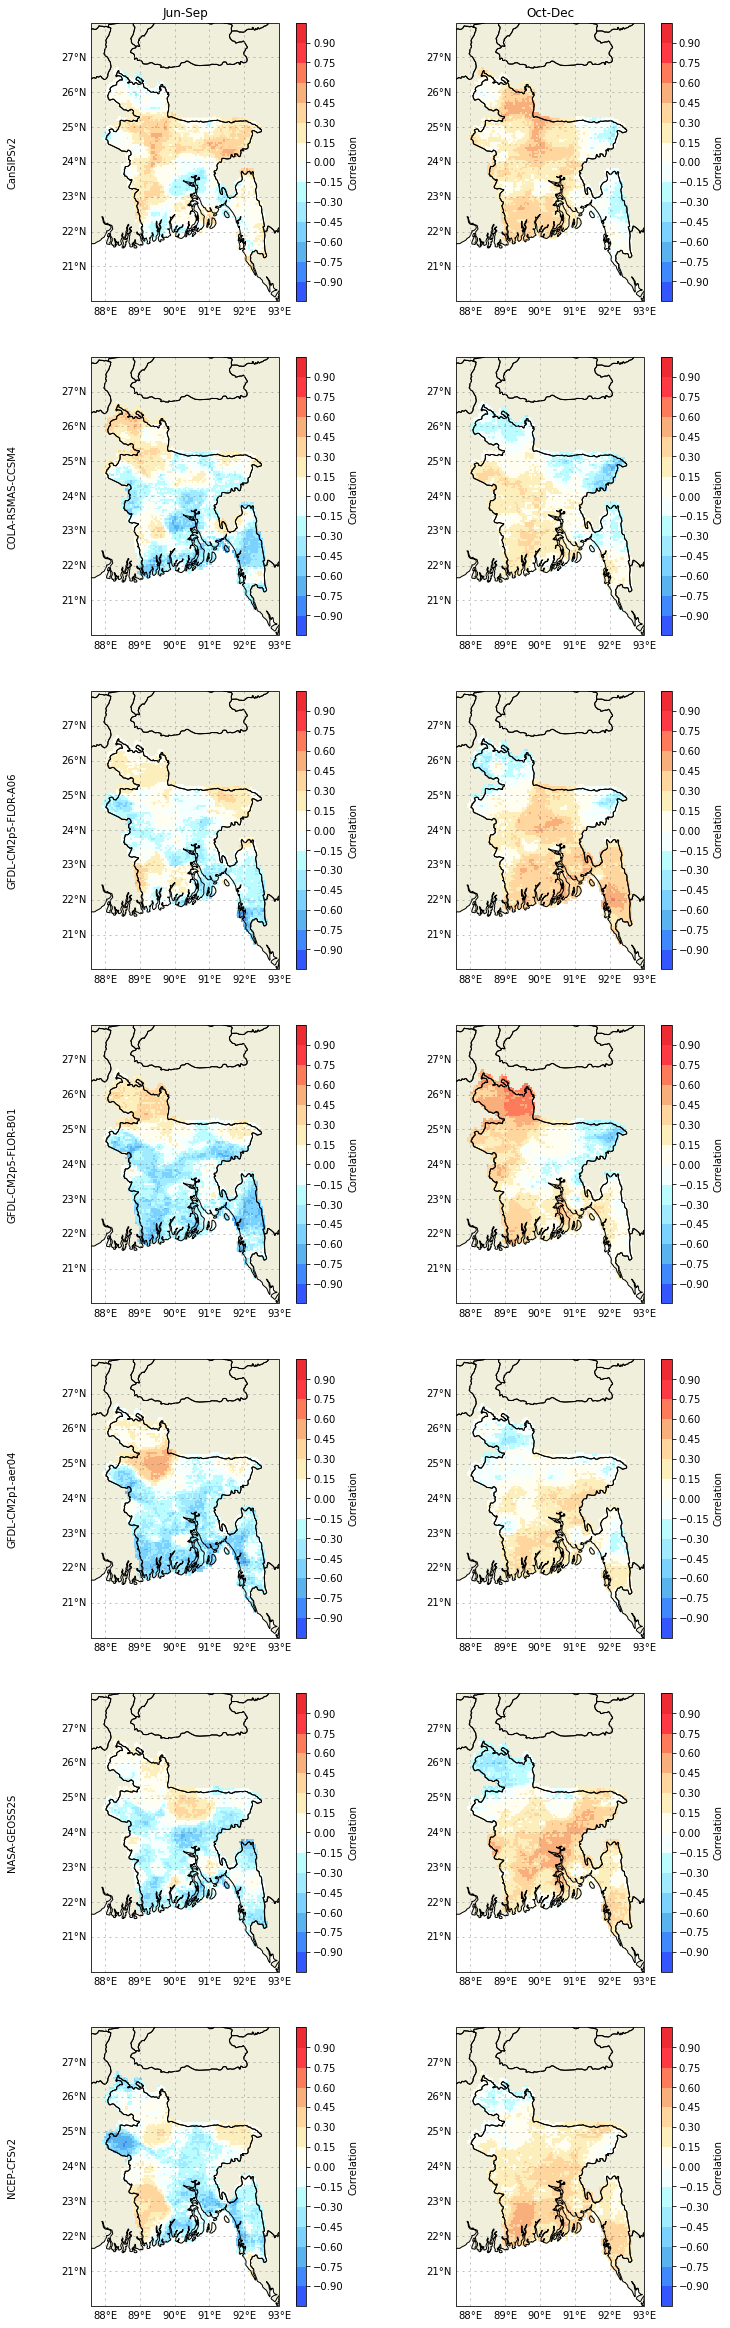

In [5]:
# Skill scores loop
for ime in range(len(met)):
    pycpt.pltmap(ime)   


##### EOF Analysis (only available if MOS=PCR or CCA)




-------------EOF 1-------------



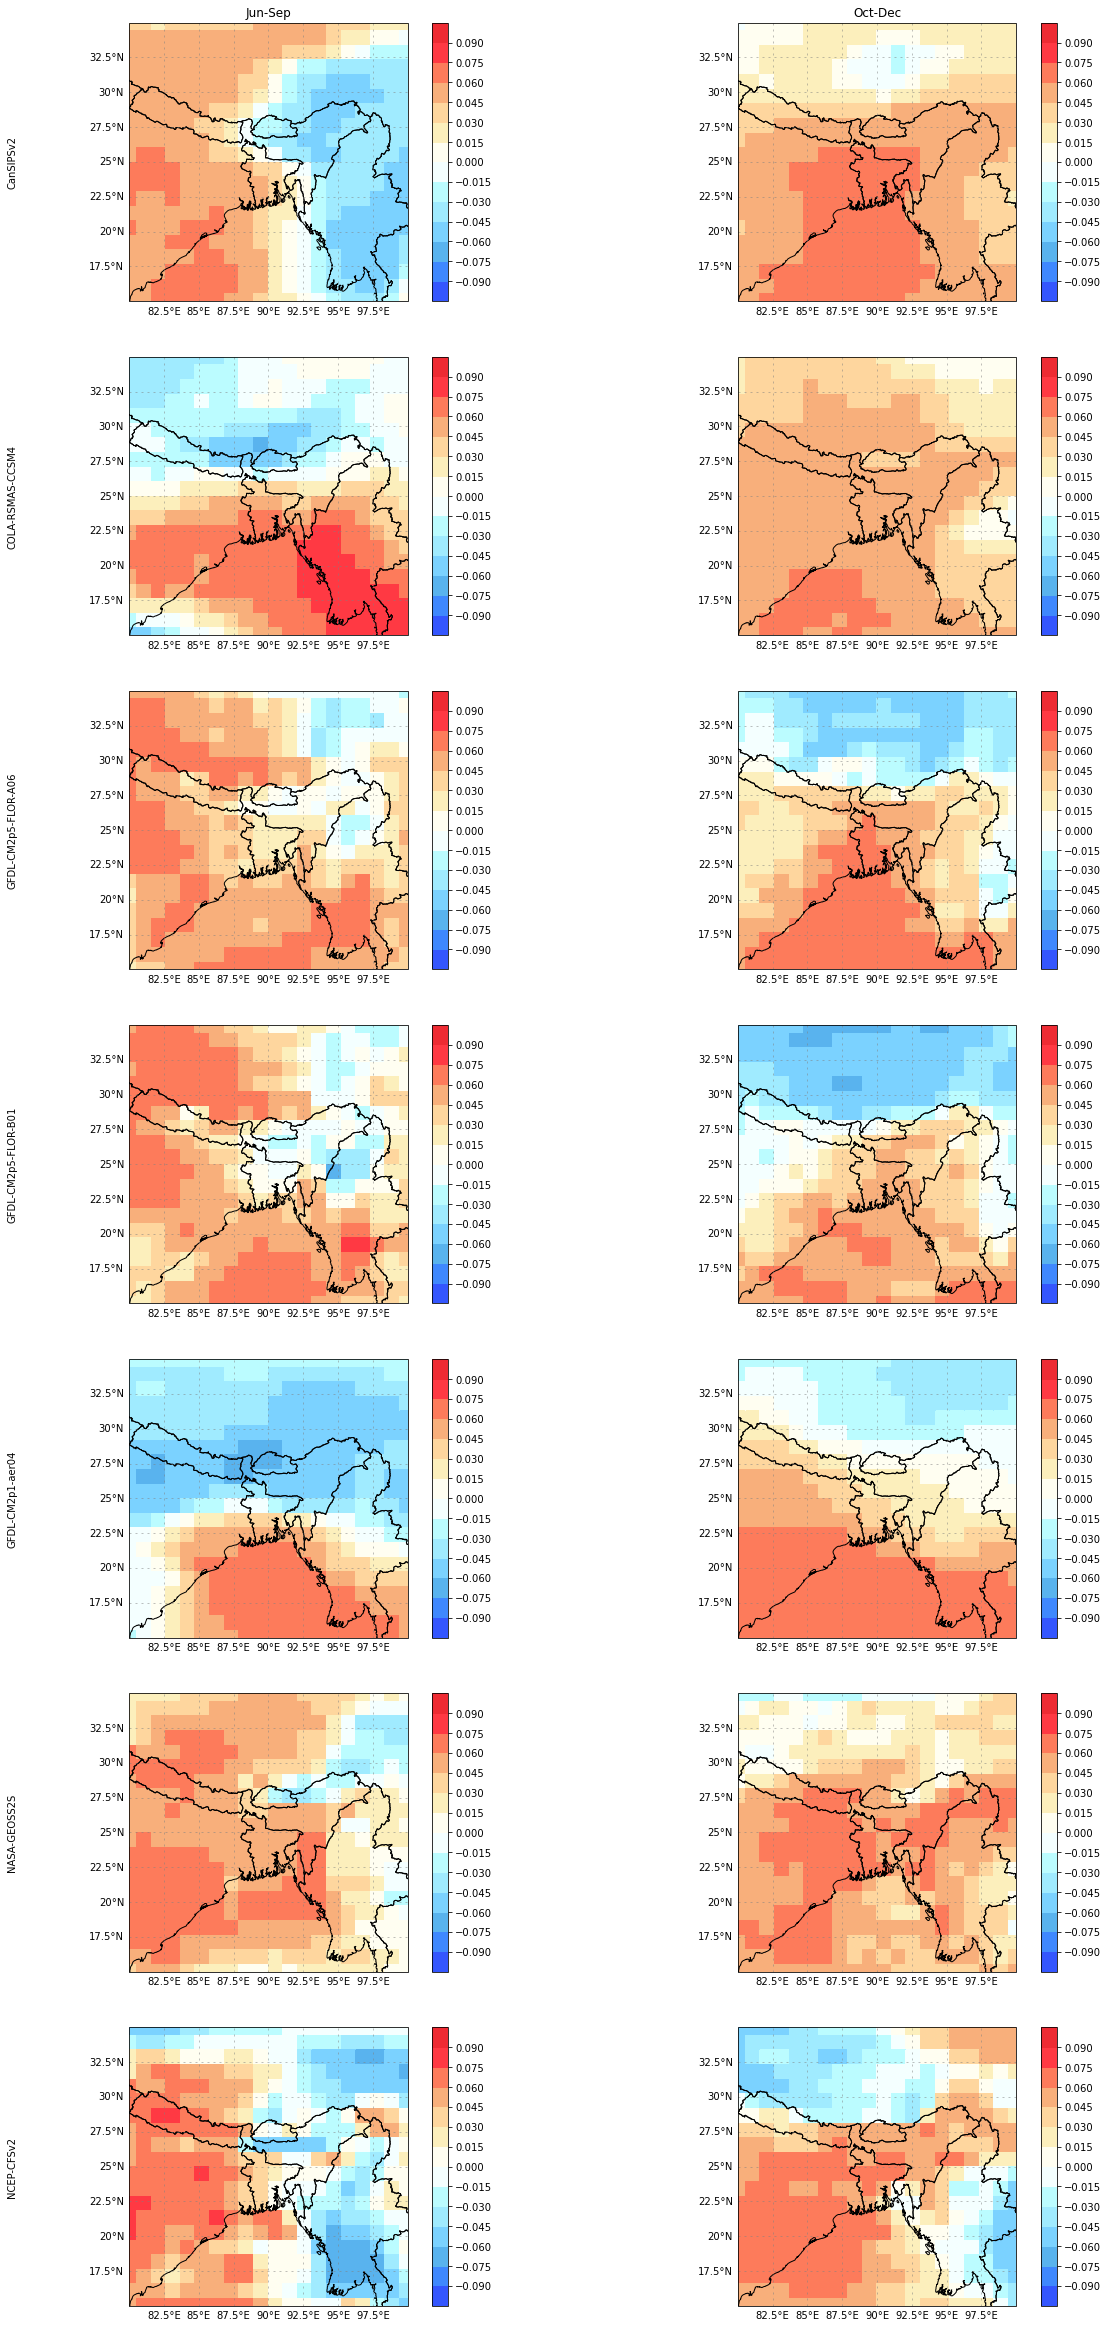




-------------EOF 2-------------



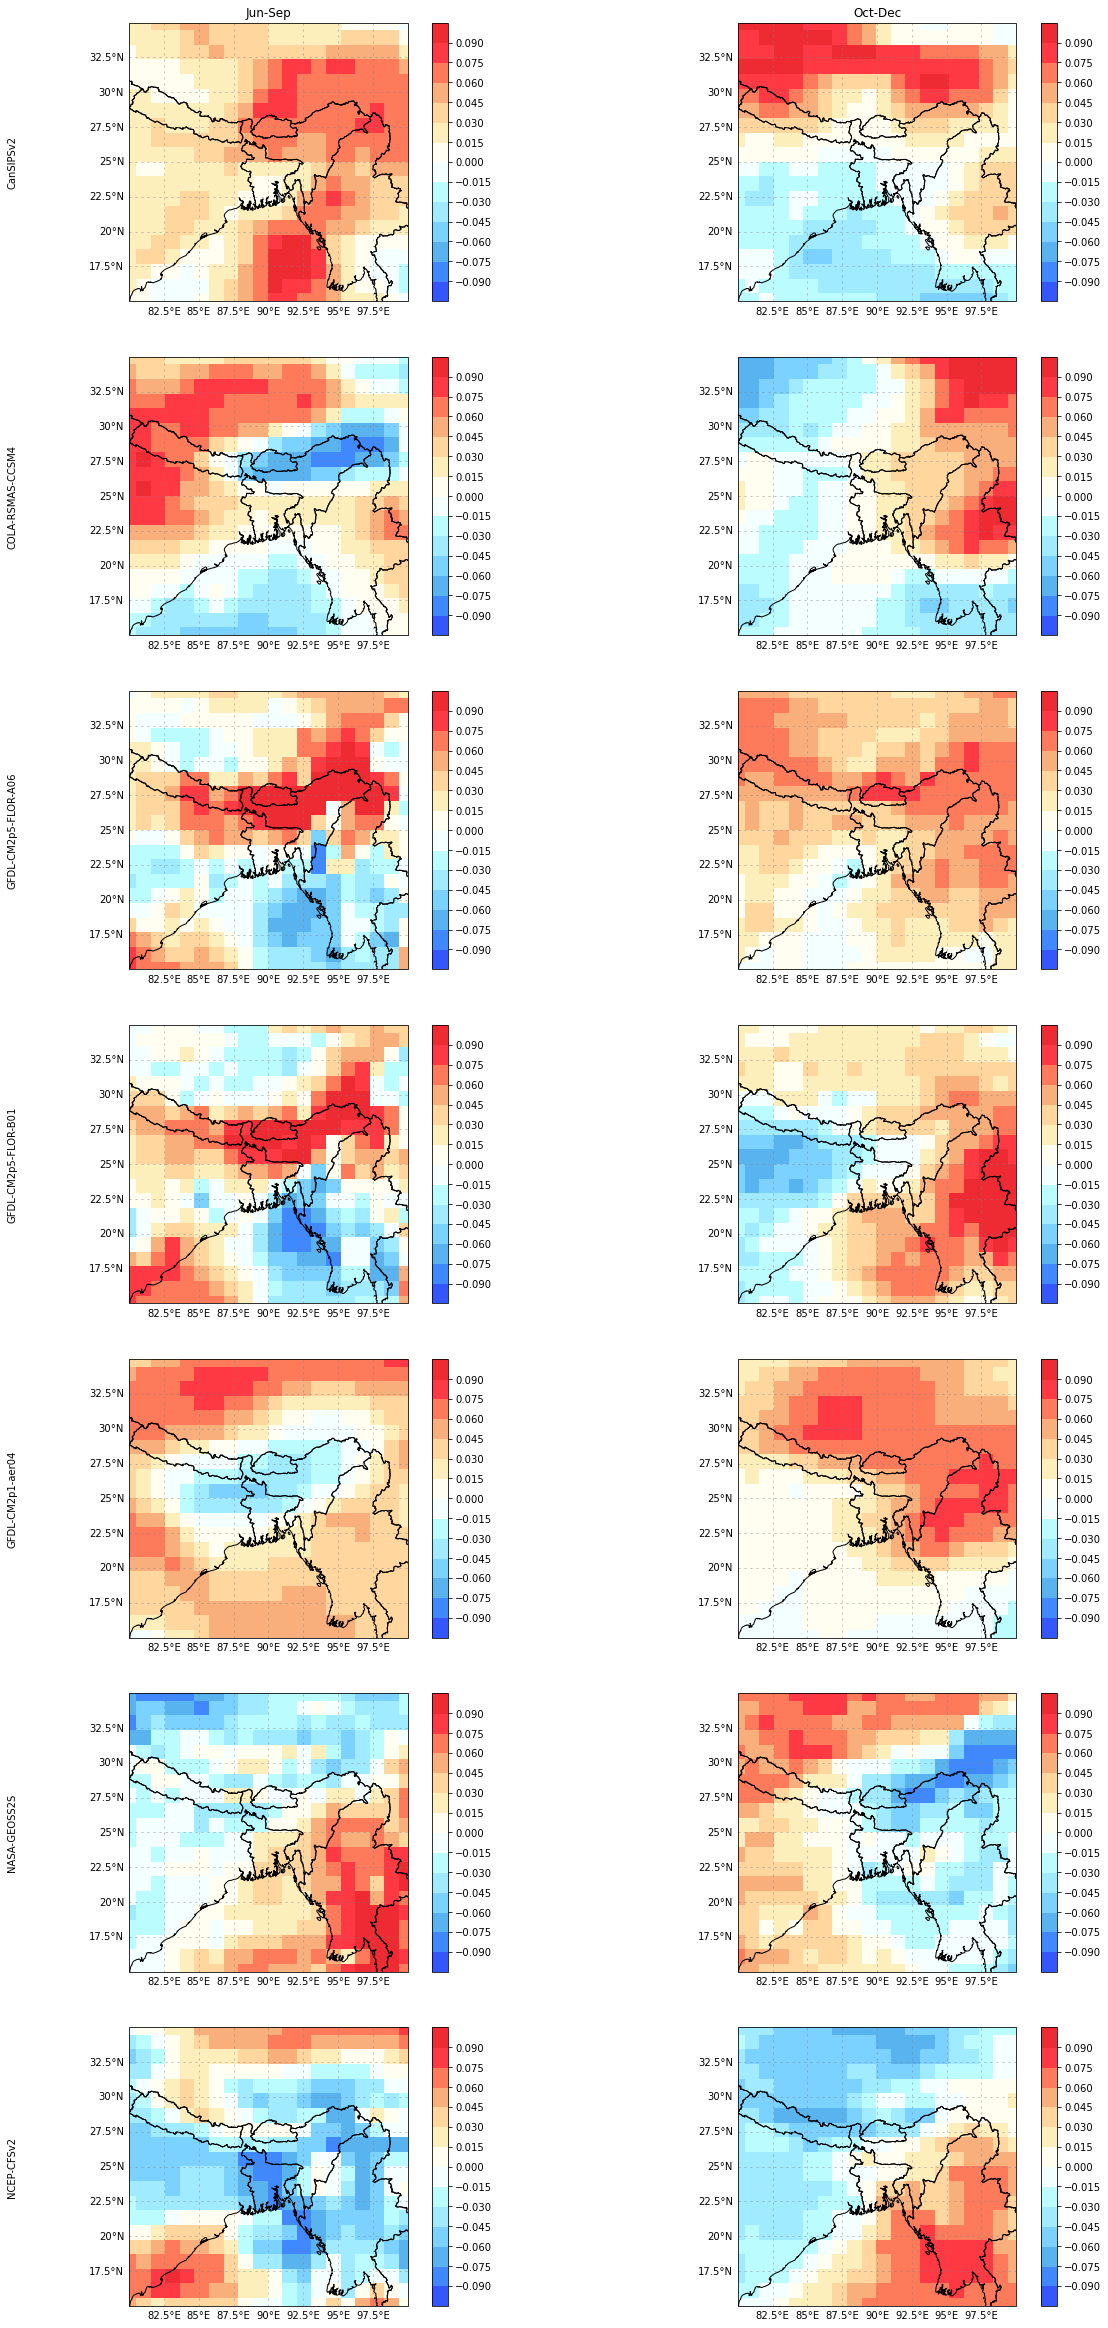




-------------EOF 3-------------



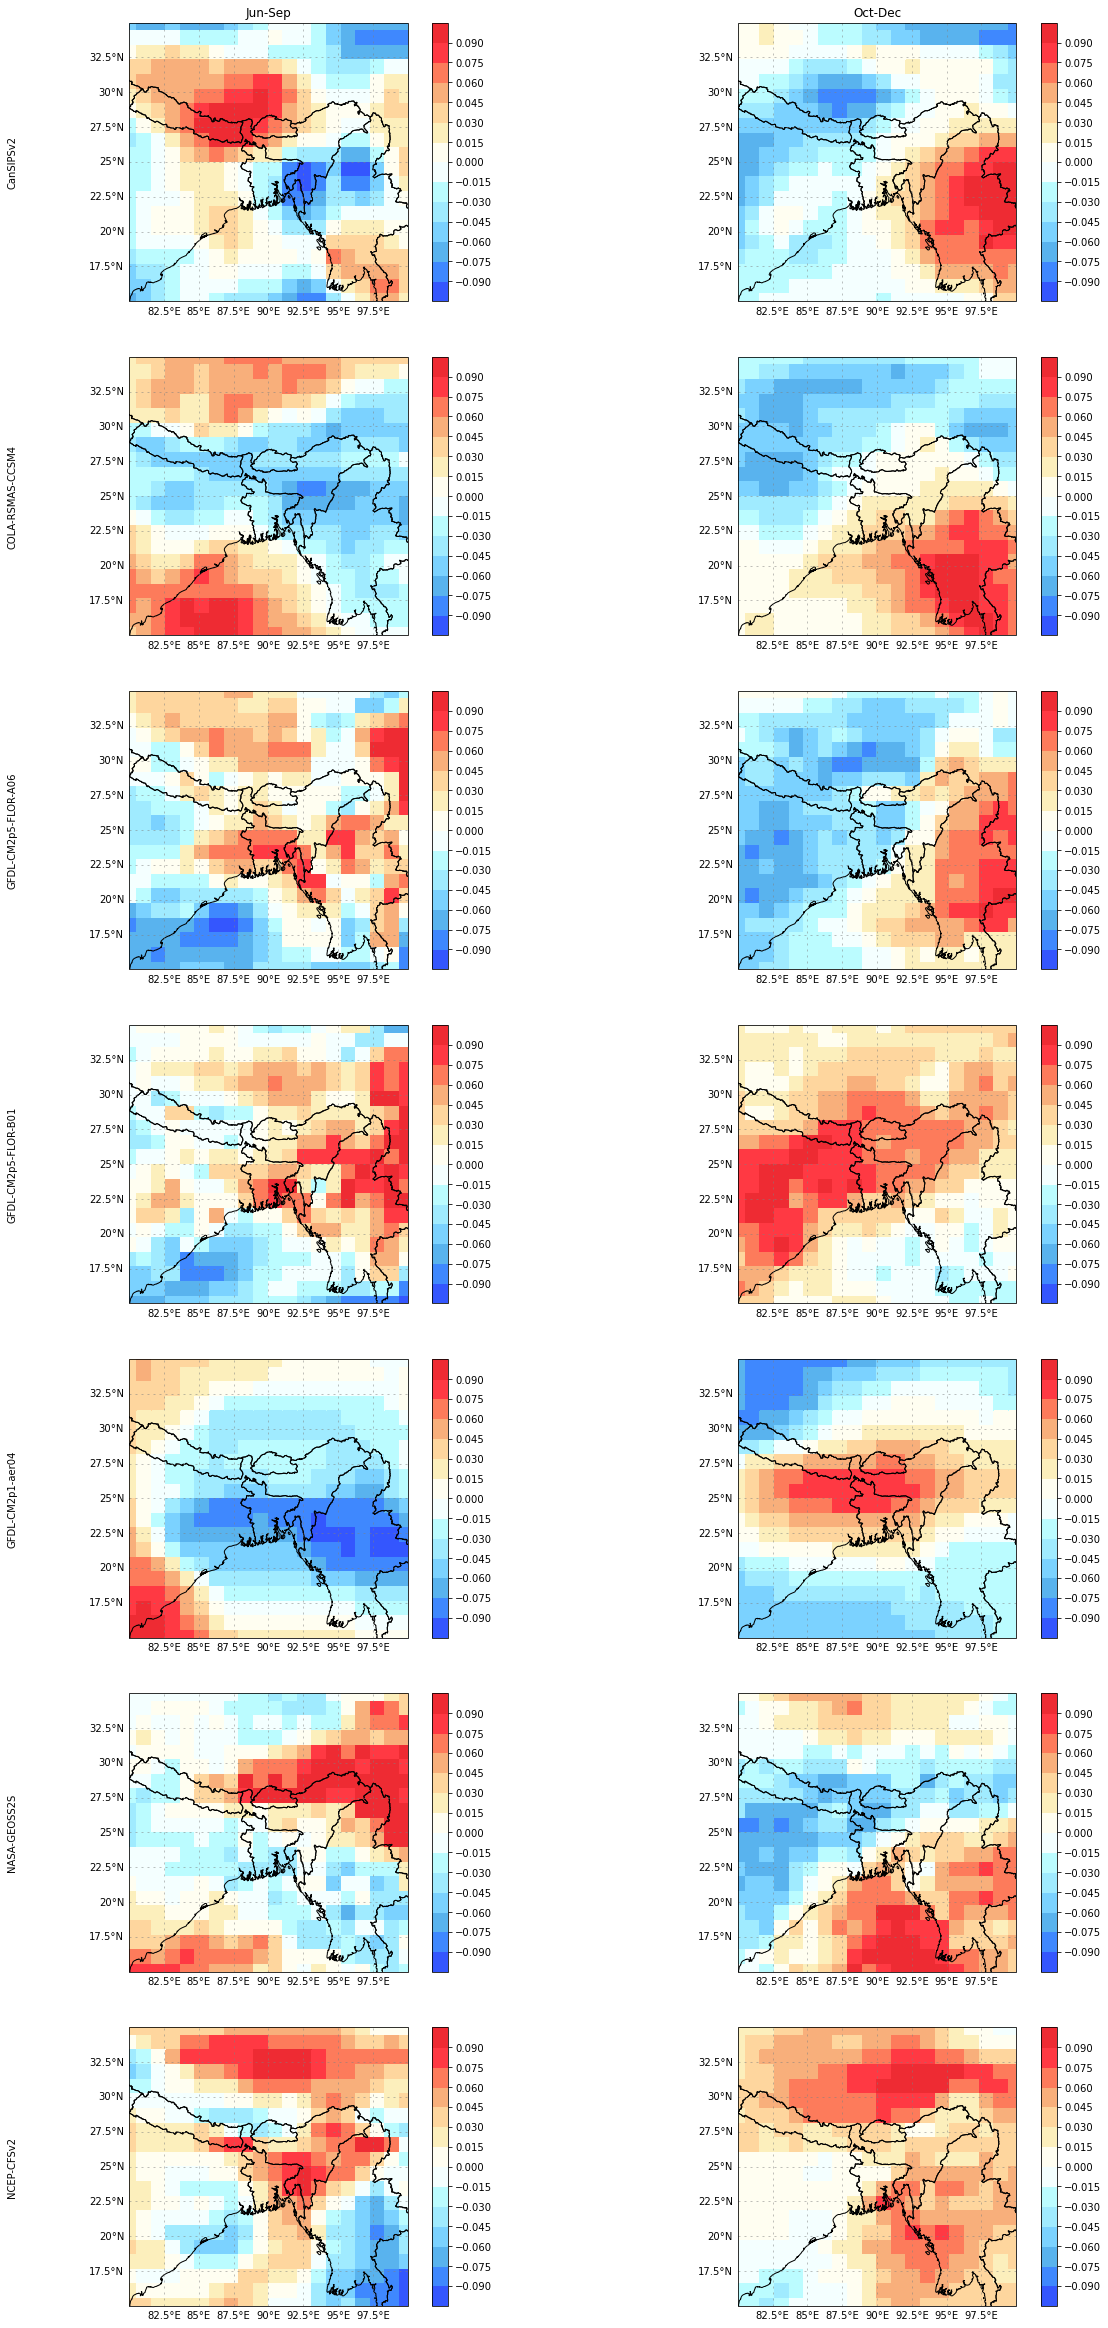

In [6]:
# Skill scores loop
for imod in range(eofmodes):
    pycpt.plteofs(imod)  

## Multi-model ensemble: NextGen

In [3]:
models=['COLA-RSMAS-CCSM4','GFDL-CM2p5-FLOR-A06']#,'CMC1-CanCM3' 'GFDL-CM2p5-FLOR-B01','GFDL-CM2p1-aer04','CMC1-CanCM3', 'CMC2-CanCM4','NCEP-CFSv2']
pycpt.setNextGenModels(models)


for tgt in range(len(tgts)):

    #prepare files for nextgen input using simple mean
    pycpt.NGensemble(tgt)

    #write CPT input script for NextGen
    pycpt.CPTscript(tgt)

    #run CPT for nextgen
    pycpt.run(tgt)

Preparing CPT files for COLA-RSMAS-CCSM4 and initialization May...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization May...
Cross-validated prediction files successfully produced
        1 file(s) copied.
Executing CPT for NextGen and initialization May...
CPT Windows version throws an error right at the end of its operation- everything should be fine for the rest of this notebook, but you need to click 'close' on the 'Access Violation' Window that pops up for now. 
----------------------------------------------
Calculations for May initialization completed!
See output folder, and check scripts/CPT_stout_train_NextGen_Jun-Sep_May.txt for errors
----------------------------------------------
----------------------------------------------



Preparing CPT files for COLA-RSMAS-CCSM4 and initialization Sep...
Preparing CPT files for GFDL-CM2p5-FLOR-A06 and initialization Sep...
Cross-validated prediction files successfully produced
        1 file(s) copied.
Executing CPT for N


Pearson


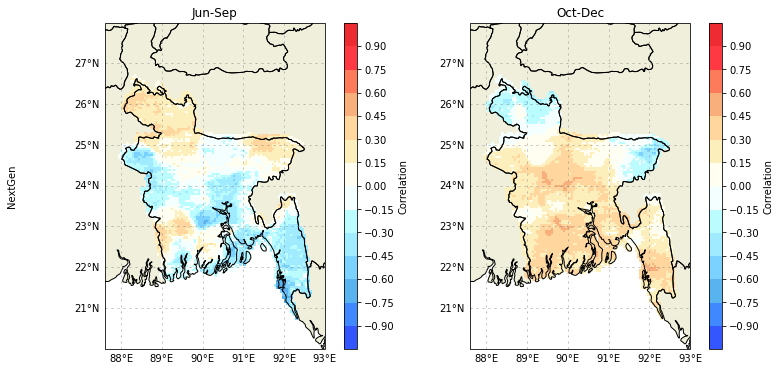

In [4]:
# Skill scores loop
for ime in range(len(met)):
    pycpt.pltmap(ime, isNextGen=1)   

# Real-Time Forecast

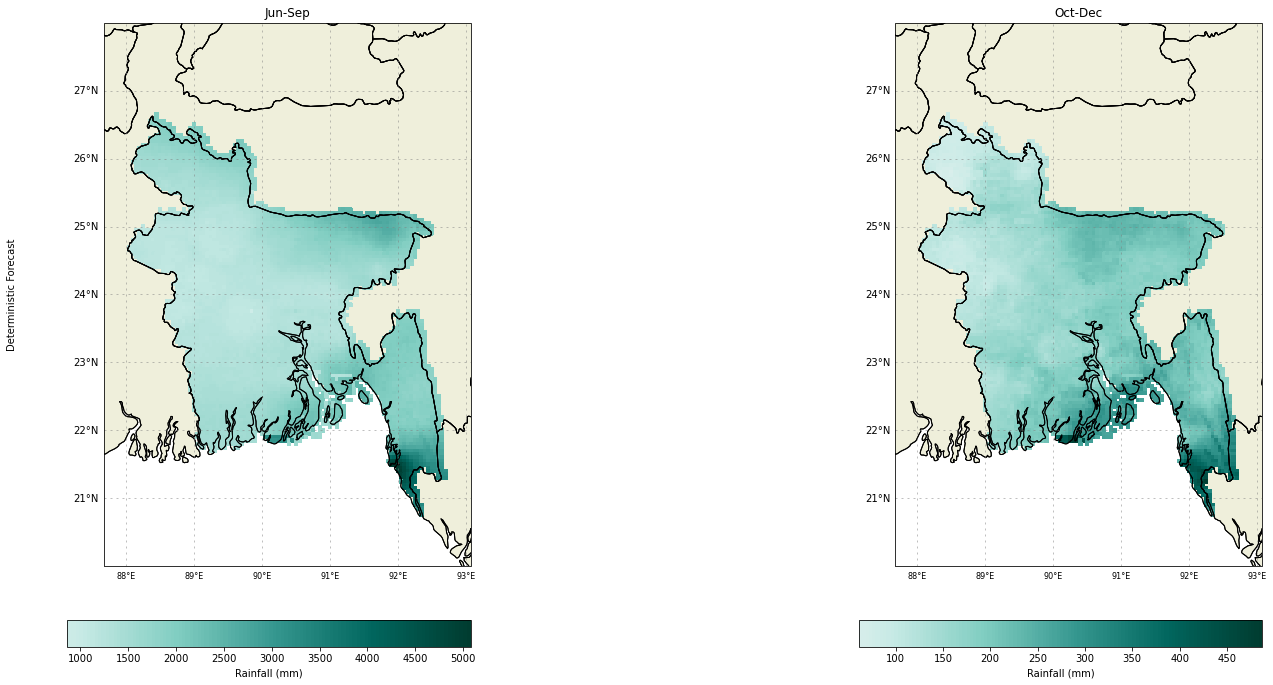

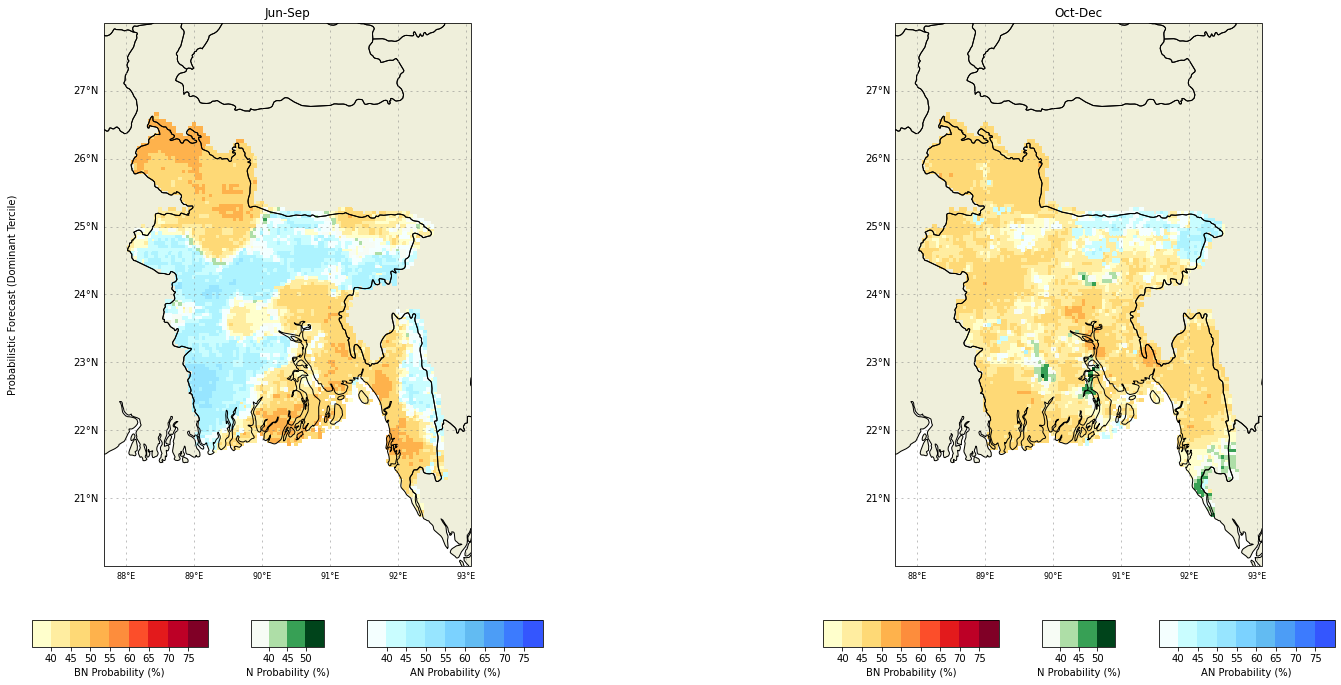

In [3]:
pycpt.plt_ng_deterministic()
pycpt.plt_ng_probabilistic()

In [3]:
pycpt.ensemblefiles(['NextGen'],work)

A subdirectory or file NextGen already exists.
Could Not Find C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\*_NextGen.tgz
Could Not Find C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\*.txt


CanSIPSv2_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_xvPr_Jun-Sep_May2020.ctl
CanSIPSv2_PRCPPRCP_PCRFCST_xvPr_Oct-Dec_Sep2020.ctl
CanSIPSv2_PRCPPRCP_PCR_2AFC_Jun-Sep_May.ctl
CanSIPSv2_PRCPPRCP_PCR_2AFC_Oct-Dec_Sep.ctl
CanSIPSv2_PRCPPRCP_PCR_EOFX_Jun-Sep_May.ctl
CanSIPSv2_PRCPPRCP_PCR_EOFX_Oct-Dec_Sep.ctl
CanSIPSv2_PRCPPRCP_PCR_Pearson_Jun-Sep_May.ctl
CanSIPSv2_PRCPPRCP_PCR_Pearson_Oct-Dec_Sep.ctl
CanSIPSv2_PRCPPRCP_PCR_RMSE_Jun-Sep_May.ctl
CanSIPSv2_PRCPPRCP_PCR_RMSE_Oct-Dec_Sep.ctl
CanSIPSv2_PRCPPRCP_PCR_RocAbove_Jun-Sep_May.ctl
CanSIPSv2_PRCPPRCP_PCR_RocAbove_Oct-Dec_Sep.ctl
CanSIPSv2_PRCPPRCP_PCR_RocBelow_Jun-Sep_May.

GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_xvPr_Jun-Sep_May2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCRFCST_xvPr_Oct-Dec_Sep2020.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_2AFC_Jun-Sep_May.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_2AFC_Oct-Dec_Sep.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_EOFX_Jun-Sep_May.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_EOFX_Oct-Dec_Sep.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_Pearson_Jun-Sep_May.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_Pearson_Oct-Dec_Sep.dat
GFDL-CM2p5-FLOR-B01_PRCPPRCP_PCR_RMSE_Jun-Sep_May.dat
GFDL-CM2p5-FLO

NCEP-CFSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep2020.dat
NCEP-CFSv2_PRCPPRCP_PCRFCST_xvPr_Jun-Sep_May2020.dat
NCEP-CFSv2_PRCPPRCP_PCRFCST_xvPr_Oct-Dec_Sep2020.dat
NCEP-CFSv2_PRCPPRCP_PCR_2AFC_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_2AFC_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_EOFX_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_EOFX_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_Pearson_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_Pearson_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_RMSE_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_RMSE_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_RocAbove_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_RocAbove_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_RocBelow_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_RocBelow_Oct-Dec_Sep.dat
NCEP-CFSv2_PRCPPRCP_PCR_Spearman_Jun-Sep_May.dat
NCEP-CFSv2_PRCPPRCP_PCR_Spearman_Oct-Dec_Sep.dat
       24 file(s) copied.
NextGen_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.ctl
NextGen_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.ctl
NextGen_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.ctl
NextGen_PRCPPRC

a CanSIPSv2_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_xvPr_Jun-Sep_May2020.ctl
a CanSIPSv2_PRCPPRCP_PCRFCST_xvPr_Jun-Sep_May2020.dat
a CanSIPSv2_PRCPPRCP_PCRFCST_xvPr_Oct-Dec_Sep2020.ctl
a CanSIPSv

a NASA-GEOSS2S_PRCPPRCP_PCR_2AFC_Oct-Dec_Sep.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_2AFC_Oct-Dec_Sep.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_EOFX_Jun-Sep_May.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_EOFX_Jun-Sep_May.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_EOFX_Oct-Dec_Sep.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_EOFX_Oct-Dec_Sep.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_Pearson_Jun-Sep_May.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_Pearson_Jun-Sep_May.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_Pearson_Oct-Dec_Sep.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_Pearson_Oct-Dec_Sep.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_RMSE_Jun-Sep_May.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_RMSE_Jun-Sep_May.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_RMSE_Oct-Dec_Sep.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_RMSE_Oct-Dec_Sep.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_RocAbove_Jun-Sep_May.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_RocAbove_Jun-Sep_May.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_RocAbove_Oct-Dec_Sep.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_RocAbove_Oct-Dec_Sep.dat
a NASA-GEOSS2S_PRCPPRCP_PCR_RocBelow_Jun-Sep_May.ctl
a NASA-GEOSS2S_PRCPPRCP_PCR_RocBelow_

Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.ctl
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep202

Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\CanSIPSv2_PRCPPRCP_PCRFCST_V_Oct-Dec_Sep202

Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NCEP-CFSv2_PRCPPRCP_PCR_Spearman_Oct-Dec_Sep.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_mu_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_mu_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_P_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_P_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_var_Jun-Sep_May2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_var_Oct-Dec_Sep2020.dat
Deleted file - C:\Users\sysadmin\Projects\PyCPT-Dev\Test_oy4\output\NextGen\NextGen_PRCPPRCP_PCRFCST_V_Jun-Sep_May2020.dat
Deleted 